In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch import optim
from collections import OrderedDict
from time import time
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
import os
import copy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Dataset : https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

In [2]:
data_dir = '/kaggle/input/satellite-image-classification'
train_dir = data_dir + '/data'

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.15 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [ ]:
def get_class_distribution(dataloader):
    class_count = {}
    for images, labels in dataloader:
        for label in labels:
            class_count[label.item()] = class_count.get(label.item(), 0) + 1
    return class_count

In [ ]:
# for images,data in trainloader:
#     print(images[0][0].shape)
#     io.imshow(images[40][0].numpy())
#     io.show()
#     break

In [ ]:
train_class_distribution = get_class_distribution(trainloader)
plt.figure(figsize=(10, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Train Loader')
plt.show()

In [ ]:
train_class_distribution = get_class_distribution(testloader)
plt.figure(figsize=(10, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Test Loader')
plt.show()

In [ ]:
train_class_distribution = get_class_distribution(validloader)
plt.figure(figsize=(10, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in valid Loader')
plt.show()

In [ ]:
model = models.resnet18(pretrained=True,weights=models.ResNet18_Weights)
model.name = "resnet18"
model

In [105]:
for param in model.parameters():
    param.requires_grad = False

In [106]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(model.fc.in_features, 256, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(256, 128, bias=True)),
                          ('fc3',nn.Linear(128,4, bias=True)),
                          ('output', nn.Softmax(dim=1))
                          ]))
model.fc = classifier

In [ ]:
model

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [108]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [109]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [ ]:
model.to(device)

In [110]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [51]:
model = train(model,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 0.9867 |  Validation Loss: 0.8190 |  Validation Accuracy: 0.9516
Epoch: 1/5 |  Training Loss: 0.8195 |  Validation Loss: 0.7772 |  Validation Accuracy: 0.9717
Epoch: 2/5 |  Training Loss: 0.2859 |  Validation Loss: 0.7656 |  Validation Accuracy: 0.9824
Epoch: 2/5 |  Training Loss: 0.7731 |  Validation Loss: 0.7598 |  Validation Accuracy: 0.9859
Epoch: 2/5 |  Training Loss: 0.7809 |  Validation Loss: 0.7702 |  Validation Accuracy: 0.9738
Epoch: 3/5 |  Training Loss: 0.5666 |  Validation Loss: 0.7583 |  Validation Accuracy: 0.9882
Epoch: 3/5 |  Training Loss: 0.7782 |  Validation Loss: 0.7576 |  Validation Accuracy: 0.9894
Epoch: 4/5 |  Training Loss: 0.0775 |  Validation Loss: 0.7559 |  Validation Accuracy: 0.9894
Epoch: 4/5 |  Training Loss: 0.7669 |  Validation Loss: 0.7567 |  Validation Accuracy: 0.9906
Epoch: 4/5 |  Training Loss: 0.7680 |  Validation Loss: 0.7542 |  Validation Accuracy: 0.9906
Epoch: 5/5 |  Training 

In [15]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [16]:
labels,predictions = pred(model,testloader)

Time:  8.048426151275635
Accuracy achieved by the network on test images is: 99%


In [18]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


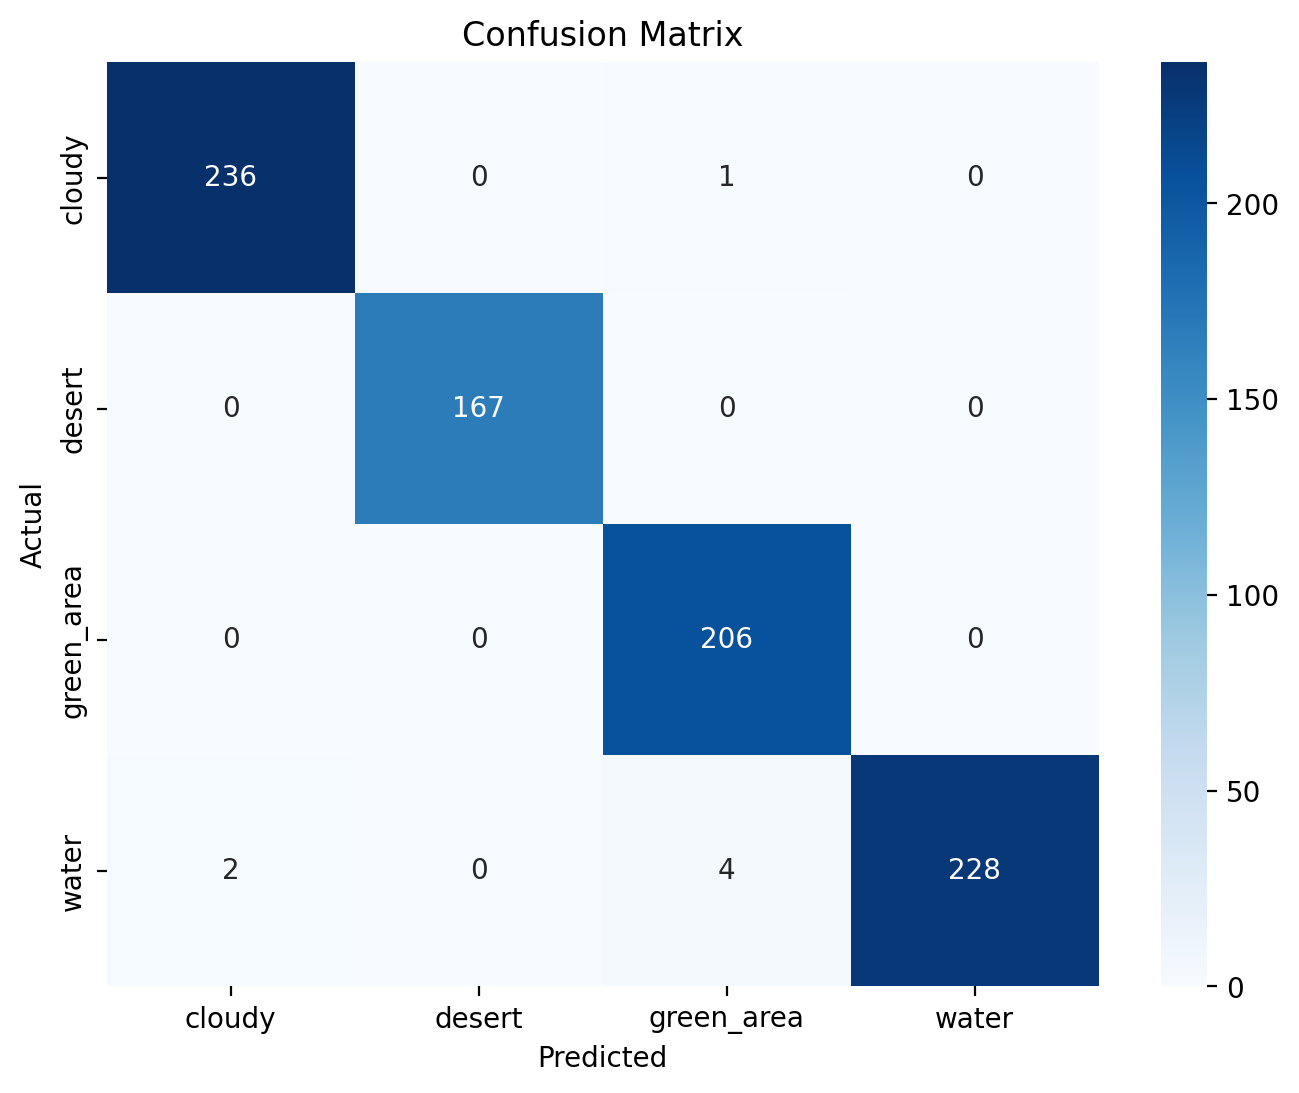

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       237
           1       1.00      1.00      1.00       167
           2       0.98      1.00      0.99       206
           3       1.00      0.97      0.99       234

    accuracy                           0.99       844
   macro avg       0.99      0.99      0.99       844
weighted avg       0.99      0.99      0.99       844



In [19]:
metrics(labels,predictions)

In [21]:
!pip install torchsummary

In [72]:
import torchsummary
print(torchsummary.summary(model.to(device),(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Quantization

## FP-16

In [53]:
model_fp16 = copy.deepcopy(model)

In [ ]:
model_fp16.half()
model_fp16.to(device)

In [55]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [73]:
labels,predictions = pred_fp16(model_fp16,testloader)

Time:  3.3999876976013184
Accuracy achieved by the network on test images is: 90%


In [ ]:
model.to('cpu')

# INT-8

### Int-8 imports

In [111]:
from torch.ao.quantization import QuantStub, DeQuantStub
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx
import copy

## PTQ

In [112]:
input_data = next(iter(trainloader))[0]  
calibrate_data = input_data.to("cpu")

In [ ]:
model.to('cpu')

In [ ]:
model_int8 = copy.deepcopy(model)
#model_int8.to(device)
qconfig_mapping = get_default_qconfig_mapping("qnnpack")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)

In [63]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [ ]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

In [ ]:
model_quantized_static

In [66]:
model_quantized_static.to('cpu')

GraphModule(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.012106122449040413, zero_point=0, padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.008618244901299477, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.02660030871629715, zero_point=158, padding=(1, 1))
    )
    (1): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.008100952953100204, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.026993542909622192, zero_point=144, padding=(1, 1))
    )
  )
  (layer2): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=0.005924284923821688, zero_point=0, p

In [67]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  14.91944670677185
Accuracy achieved by the network on test images is: 91%


Confusion Matrix:


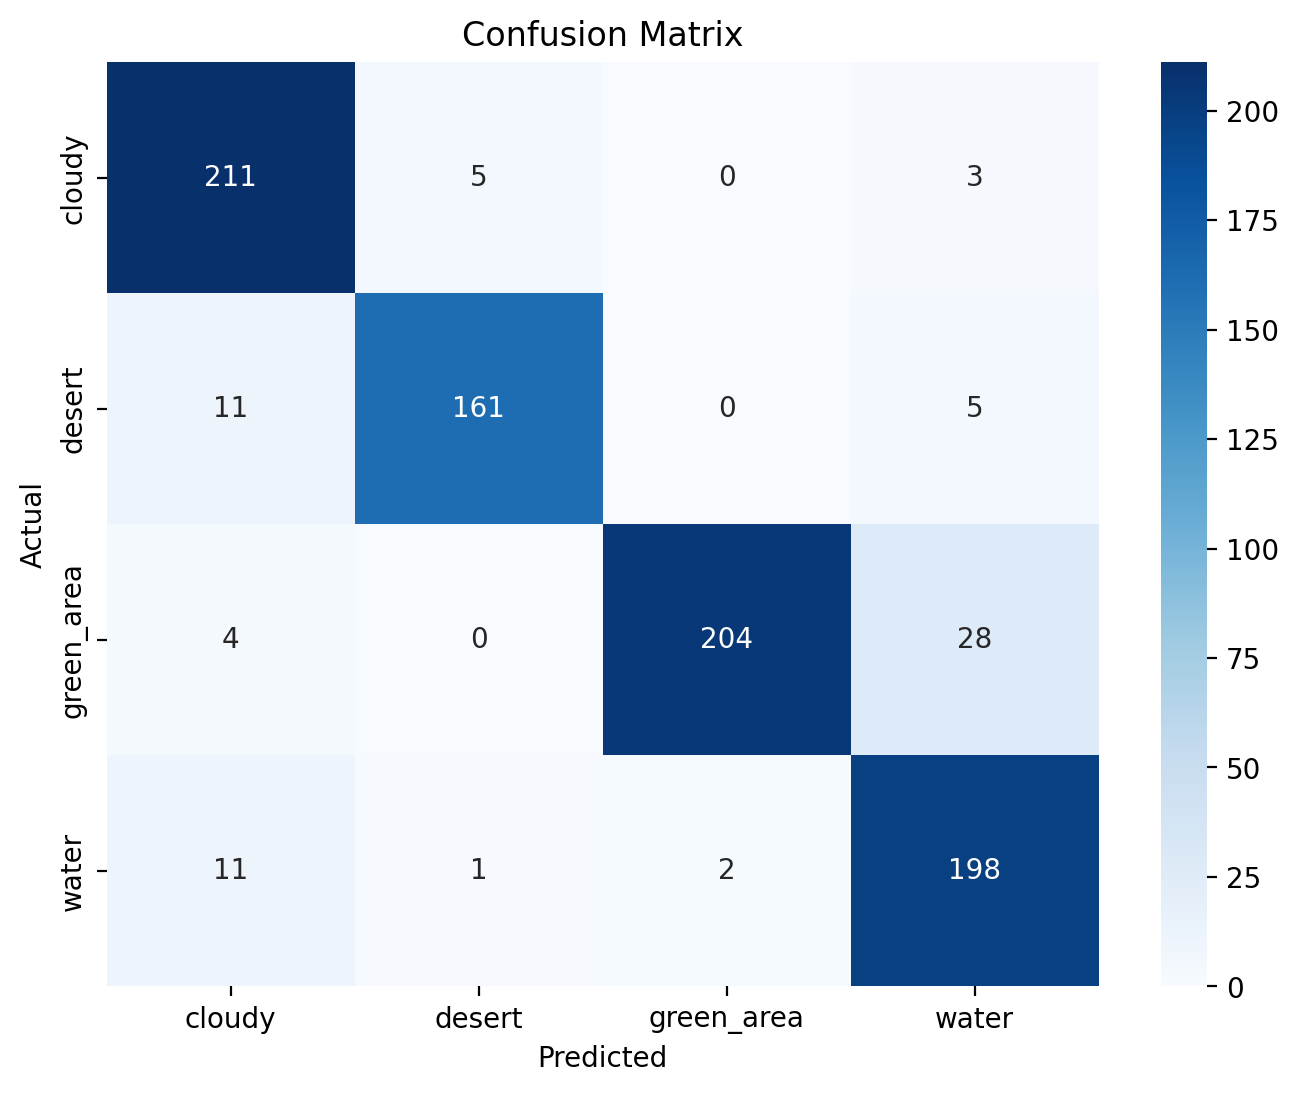

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       219
           1       0.96      0.91      0.94       177
           2       0.99      0.86      0.92       236
           3       0.85      0.93      0.89       212

    accuracy                           0.92       844
   macro avg       0.92      0.92      0.92       844
weighted avg       0.92      0.92      0.92       844



In [68]:
metrics(all_predictions_int8,all_labels_int8)

In [69]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [70]:
print('Resnet-18 fp32 size : ',end='')
print_model_size(model)
print('Resnet-18 Int8 size : ',end='')
print_model_size(model_quantized_static)

Resnet-18 fp32 size : 45.31 MB
Resnet-18 Int8 size : 11.35 MB


## QAT

### Load a new resnet model which is not trained before starting qat

In [114]:
#calibration data
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [ ]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

In [116]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [ ]:
model_prepared.to(device)

In [118]:
model_prepared = train(model_prepared,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 1.2073 |  Validation Loss: 1.0544 |  Validation Accuracy: 0.8055
Epoch: 1/5 |  Training Loss: 0.9409 |  Validation Loss: 0.8511 |  Validation Accuracy: 0.9103
Epoch: 2/5 |  Training Loss: 0.3117 |  Validation Loss: 0.8855 |  Validation Accuracy: 0.8713
Epoch: 2/5 |  Training Loss: 0.8335 |  Validation Loss: 0.8813 |  Validation Accuracy: 0.8729
Epoch: 2/5 |  Training Loss: 0.8295 |  Validation Loss: 0.7859 |  Validation Accuracy: 0.9693
Epoch: 3/5 |  Training Loss: 0.5912 |  Validation Loss: 0.7803 |  Validation Accuracy: 0.9691
Epoch: 3/5 |  Training Loss: 0.7972 |  Validation Loss: 0.7791 |  Validation Accuracy: 0.9691
Epoch: 4/5 |  Training Loss: 0.0787 |  Validation Loss: 0.7894 |  Validation Accuracy: 0.9570
Epoch: 4/5 |  Training Loss: 0.7985 |  Validation Loss: 0.7779 |  Validation Accuracy: 0.9736
Epoch: 4/5 |  Training Loss: 0.7925 |  Validation Loss: 0.7671 |  Validation Accuracy: 0.9787
Epoch: 5/5 |  Training 

In [ ]:
model_prepared.to('cpu')

In [120]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [121]:
model_quantized_trained.to('cpu')

GraphModule(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.05461735278367996, zero_point=0, padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.035785578191280365, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.1143171638250351, zero_point=76, padding=(1, 1))
    )
    (1): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.029523445293307304, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.09117480367422104, zero_point=74, padding=(1, 1))
    )
  )
  (layer2): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=0.02268926054239273, zero_point=0, padding

In [122]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  16.062243223190308
Accuracy achieved by the network on test images is: 96%


In [123]:
print_model_size(model_quantized_trained)

11.48 MB


Confusion Matrix:


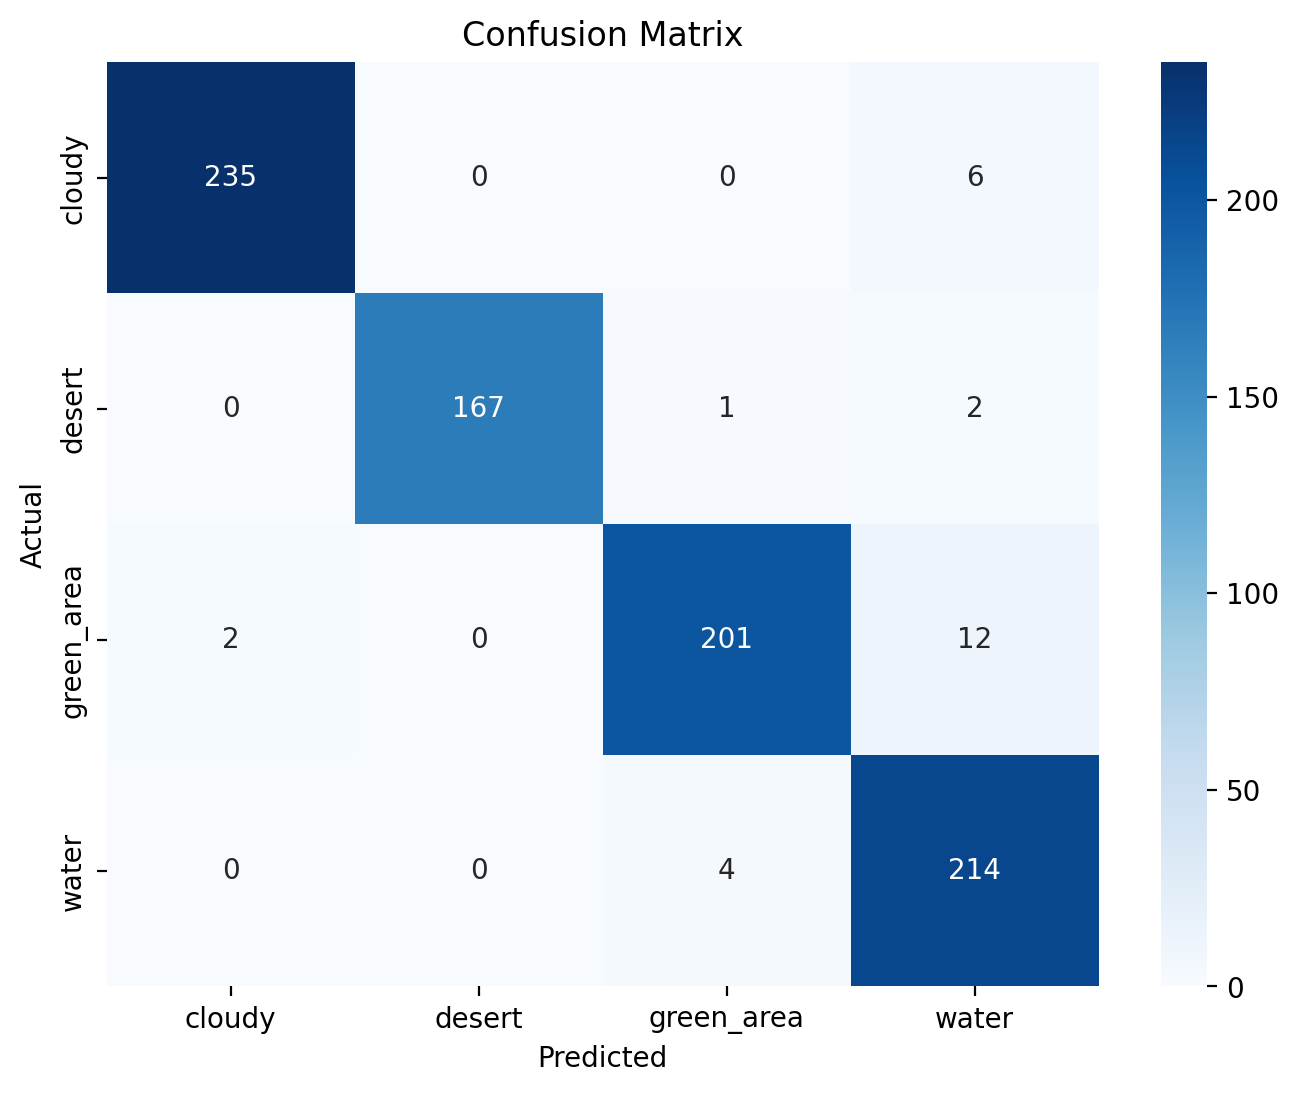

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       241
           1       1.00      0.98      0.99       170
           2       0.98      0.93      0.95       215
           3       0.91      0.98      0.95       218

    accuracy                           0.97       844
   macro avg       0.97      0.97      0.97       844
weighted avg       0.97      0.97      0.97       844



In [124]:
metrics(all_predictions_int8,all_labels_int8)